# Objectron Geometry Tutorial

This notebook shows how to parse the geometry.pbdata for each sequence. Geometry.pbdata contains the AR Metadata information for each sequence. 

In [1]:
import numpy as np
import os
import requests
import struct
import sys
import subprocess
import cv2

from IPython.core.display import display,HTML
import matplotlib.pyplot as plt

# I'm running this Jupyter notebook locally. Manually import the objectron module.
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
# The AR Metadata captured with each frame in the video
from objectron.schema import a_r_capture_metadata_pb2 as ar_metadata_protocol
# The annotations are stored in protocol buffer format. 
from objectron.schema import object_pb2 as object_protocol
from objectron.schema import annotation_data_pb2 as annotation_protocol
import objectron.dataset.box as Box

First, let's download a video and corresponding metadata from the Objectron bucket. The bucket allows public (unauthenticated) http access, so we can directly download the file from the bucket.

In [203]:
from os import path
import glob
import os
import struct
import sys
import cv2
import matplotlib.pyplot as plt
import numpy as np
import requests
from matplotlib import image

video_id = 'bottle/batch-10/15'
# download_dir = './nerf_data'
v_id = 'bottle_batch-10_15'
download_dir = './Objectron_data/'+v_id

public_url = "https://storage.googleapis.com/objectron"
os.makedirs(download_dir, exist_ok=True)
video_filename = f'{public_url}/videos/{video_id}/video.MOV'
public_url = "https://storage.googleapis.com/objectron"
urls = [f'{public_url}/videos/{video_id}/video.MOV',
       f'{public_url}/videos/{video_id}/sfm_arframe.pbdata',
       f'{public_url}/videos/{video_id}/geometry.pbdata',
       f'{public_url}/annotations/{video_id}.pbdata']
for url in urls:
    with open(path.join(download_dir, path.basename(url)), "wb") as f:
        f.write(requests.get(url).content)
        

# public_url = "https://storage.googleapis.com/objectron"
# blob_path = public_url + "/v1/index/shoe_annotations_train"
# video_ids = requests.get(blob_path).text
# video_ids = video_ids.split('\n')
# # Download the first ten videos in cup test dataset
# for i in range(1):
#     video_filename = public_url + "/videos/" + video_ids[i] + "/video.MOV"
#     metadata_filename = public_url + "/videos/" + video_ids[i] + "/geometry.pbdata"
#     annotation_filename = public_url + "/annotations/" + video_ids[i] + ".pbdata"
#     # video.content contains the video file.
#     video = requests.get(video_filename)
#     metadata = requests.get(metadata_filename)
    
#     # Please refer to Parse Annotation tutorial to see how to parse the annotation files.
#     annotation = requests.get(annotation_filename)
    
#     file = open("video.MOV", "wb")
#     file.write(video.content)
#     file.close()
    
#     file = open("geometry.pbdata", "wb")
#     file.write(metadata.content)
#     file.close()
    
#     file = open("annotation.pbdata", "wb")
#     file.write(annotation.content)
#     file.close()

!ls

 3D_IOU.ipynb				     Objectron_data
'Download Data.ipynb'			     objectron-geometry-tutorial.ipynb
'Hello World.ipynb'			     Objectron_NeRF_Tutorial.ipynb
 images_12				     Objectron_Pytorch_tutorial.ipynb
 __init__.py				    'Parse Annotations.ipynb'
 nerf_data				     SequenceExamples.ipynb
 objectron-3dprojection-hub-tutorial.ipynb


## Parsing geometry.pbdata

The geometry.pbdata is slightly unconventional, as it is packed with a series of a_r_capture_metadata, for each frame in the video. For each a_r_capture_metadata is preceeded by four-bytes that specify the length of the message.

We can grab different fields from teh frame_data. For the list of available fields and their desription see the [a_r_capture_metadata.proto](https://github.com/google-research-datasets/Objectron/blob/master/objectron/schema/a_r_capture_metadata.proto)

Here we care about the `ARFrame` message and the fields there in. Specifically, the `camera` contains the information about the camera pose, the `plane_anchor` contains planes information in the scene and `raw_feature_points` contains the 3D point cloud used by the AR tracking system. 

In [204]:
def get_geometry_data(geometry_filename):
    sequence_geometry = []
    with open(geometry_filename, 'rb') as pb:
        proto_buf = pb.read()

        i = 0
        frame_number = 0

        while i < len(proto_buf):
            # Read the first four Bytes in little endian '<' integers 'I' format
            # indicating the length of the current message.
            msg_len = struct.unpack('<I', proto_buf[i:i + 4])[0]
            i += 4
            message_buf = proto_buf[i:i + msg_len]
            i += msg_len
            frame_data = ar_metadata_protocol.ARFrame()
            frame_data.ParseFromString(message_buf)


            transform = np.reshape(frame_data.camera.transform, (4, 4))
            projection = np.reshape(frame_data.camera.projection_matrix , (4, 4))
            view = np.reshape(frame_data.camera.view_matrix , (4, 4))
            position = transform[:3, -1]

            current_points = [np.array([v.x, v.y, v.z])
                              for v in frame_data.raw_feature_points.point]
            current_points = np.array(current_points)

            sequence_geometry.append((transform, projection, view, current_points))
    return sequence_geometry

Similarly we can parse the annotation protos as well. The annotation protos also contains a copy of the ARCamera message too, which will be used to projects the 3D Bounding box to the image plane. For projecting the points from 3D to 2D, you can either 1) transform * extrinsics, or use 2) projection * view. Approach 1 is popular in 3D geometry community, while 2) is used often by computer graphics folks. For more details see this [OpenGL tutorial](http://www.songho.ca/opengl/gl_camera.html).

In [205]:
def get_frame_annotation(annotation_filename):
    """Grab an annotated frame from the sequence."""
    result = []
    instances = []
    with open(annotation_filename, 'rb') as pb:
        sequence = annotation_protocol.Sequence()
        sequence.ParseFromString(pb.read())

        object_id = 0
        object_rotations = []
        object_translations = []
        object_scale = []
        num_keypoints_per_object = []
        object_categories = []
        annotation_types = []
        
        # Object instances in the world coordinate system, These are stored per sequence, 
        # To get the per-frame version, grab the transformed keypoints from each frame_annotation
        for obj in sequence.objects:
            rotation = np.array(obj.rotation).reshape(3, 3)
            translation = np.array(obj.translation)
            scale = np.array(obj.scale)
            points3d = np.array([[kp.x, kp.y, kp.z] for kp in obj.keypoints])
            instances.append((rotation, translation, scale, points3d))
        
        # Grab teh annotation results per frame
        for data in sequence.frame_annotations:
            # Get the camera for the current frame. We will use the camera to bring
            # the object from the world coordinate to the current camera coordinate.
            transform = np.array(data.camera.transform).reshape(4, 4)
            view = np.array(data.camera.view_matrix).reshape(4, 4)
#             print("transform", transform)
#             print("view", view)
#             print("inv trasnform", np.linalg.inv(transform))

            intrinsics = np.array(data.camera.intrinsics).reshape(3, 3)
            projection = np.array(data.camera.projection_matrix).reshape(4, 4)
            intrinsics_matrix = np.eye(4)
            intrinsics_matrix[:3,:3] = intrinsics
            
#             print("intrsinsics", intrinsics[0]/(1920/2))
#             print("P00",projection[0,0])
        
            keypoint_size_list = []
            object_keypoints_2d = []
            object_keypoints_3d = []
            for annotations in data.annotations:
                num_keypoints = len(annotations.keypoints)
                keypoint_size_list.append(num_keypoints)
                for keypoint_id in range(num_keypoints):
                    keypoint = annotations.keypoints[keypoint_id]
                    object_keypoints_2d.append((keypoint.point_2d.x, keypoint.point_2d.y, keypoint.point_2d.depth))
                    object_keypoints_3d.append((keypoint.point_3d.x, keypoint.point_3d.y, keypoint.point_3d.z))
                num_keypoints_per_object.append(num_keypoints)
                object_id += 1
            result.append((object_keypoints_2d, object_keypoints_3d, keypoint_size_list, view, projection, intrinsics))

    return result, instances

This is a helper function to extract a few image frames from the video file using ffmpeg utility.

In [206]:
def grab_frame(video_file, frame_ids):
  """Grab an image frame from the video file."""
  frames = []
  capture = cv2.VideoCapture(video_file)
  width = int(capture.get(cv2.CAP_PROP_FRAME_HEIGHT))
  height = int(capture.get(cv2.CAP_PROP_FRAME_WIDTH))
  capture.release()
  frame_size = width * height * 3

  for frame_id in frame_ids:
    frame_filter = r'select=\'eq(n\,{:d})\''.format(frame_id)
    command = [
        'ffmpeg', '-i', video_file, '-f', 'image2pipe', '-vf', frame_filter,
        '-pix_fmt', 'rgb24', '-vcodec', 'rawvideo', '-vsync', 'vfr', '-'
    ]
    pipe = subprocess.Popen(
        command, stdout=subprocess.PIPE, bufsize = 151 * frame_size)
    current_frame = np.frombuffer(
        pipe.stdout.read(frame_size), dtype='uint8').reshape(width, height, 3)
    pipe.stdout.flush()

    frames.append(current_frame)
  return frames

# Projecting Points from 3D to 2D

We go over the sequence and for a few frames:
1. Compute the 3D bounding box (vertices in 3D)
2. Project those points to image using the camera information
3. Project the scene point-cloud to the image plane

In [207]:
def project_points(points, projection_matrix, view_matrix, width, height):
    p_3d = np.concatenate((points, np.ones_like(points[:, :1])), axis=-1).T
    p_3d_cam = np.matmul(view_matrix, p_3d)
    p_2d_proj = np.matmul(projection_matrix, p_3d_cam)
    # Project the points
    p_2d_ndc = p_2d_proj[:-1, :] / p_2d_proj[-1, :]
    p_2d_ndc = p_2d_ndc.T

    # Convert the 2D Projected points from the normalized device coordinates to pixel values
    x = p_2d_ndc[:, 1]
    y = p_2d_ndc[:, 0]
    pixels = np.copy(p_2d_ndc)
    pixels[:, 0] = ((1 + x) * 0.5) * width
    pixels[:, 1] = ((1 + y) * 0.5) * height    
    pixels = pixels.astype(int)
    return pixels

In [208]:
%%bash
cd ./Objectron_data/bottle_batch-10_15
mkdir -p "images_12"
ffmpeg -i video.MOV -vsync vfr -vf "scale=iw/12:ih/12" -start_number 0 "images_12/%05d.png"

ffmpeg version 3.4.11-0ubuntu0.1 Copyright (c) 2000-2022 the FFmpeg developers
  built with gcc 7 (Ubuntu 7.5.0-3ubuntu1~18.04)
  configuration: --prefix=/usr --extra-version=0ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --enable-gpl --disable-stripping --enable-avresample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librubberband --enable-librsvg --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvorbis --enable-libvpx --enable-libwavpack --enable-libwebp --enable-libx265 --enable-libxml2 --enable-libxvid --enable-li

(9, 3)
points_2d_aray (9, 3)
[[ 7.22804543e+01  7.96968375e+01  8.29293316e-02]
 [ 6.39229098e+01  1.27426123e+02  8.30259907e-02]
 [ 4.42629316e+01  1.44267931e+02  8.29591813e-02]
 [ 6.88216149e+01  9.33997191e+00  8.29591110e-02]
 [ 4.50555684e+01 -1.94441028e+00  8.28551407e-02]
 [ 9.21918992e+01  1.39406738e+02  8.29835926e-02]
 [ 7.63374070e+01  1.62220033e+02  8.28944027e-02]
 [ 1.05156280e+02  3.92896758e+00  8.28943059e-02]
 [ 8.83074039e+01 -1.18318226e+01  8.27439721e-02]]
44 105 -11 162
cropped (160, 61, 3)


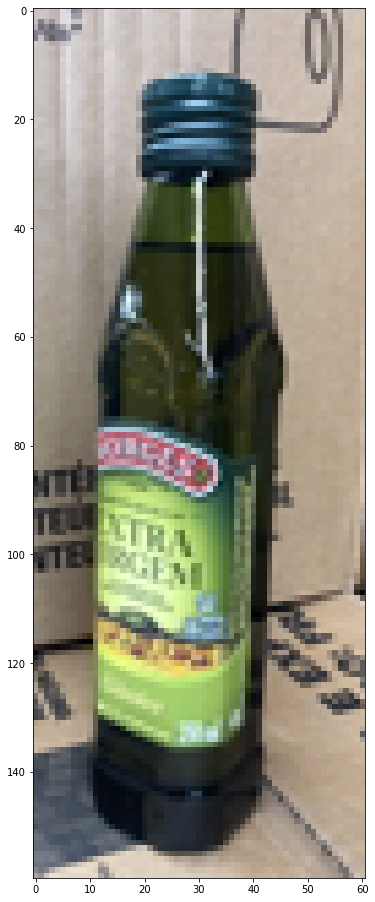

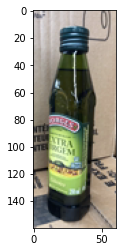

new image size (160, 61, 3)


error: OpenCV(4.5.4-dev) :-1: error: (-5:Bad argument) in function 'circle'
> Overload resolution failed:
>  - Layout of the output array img is incompatible with cv::Mat
>  - Expected Ptr<cv::UMat> for argument 'img'


In [211]:
# Grab some frames from the video file.
from PIL import Image
from torchvision import transforms as T

frame_ids = [109]
num_frames = len(frame_ids)
sequence_filenames = sorted(glob.glob('/home/zubair/Objectron/notebooks/Objectron_data/bottle_batch-10_15/images_12/*.png'))
sequence_geometry = get_geometry_data(path.join(download_dir, 'sfm_arframe.pbdata'))
frames = grab_frame(path.join(download_dir, 'video.MOV'), frame_ids)
annotation_data, instances = get_frame_annotation(path.join(download_dir, '15.pbdata'))
fig, ax = plt.subplots(1, num_frames, figsize = (12, 16))

def project(K, p_3d):
    projections_2d = np.zeros((2, p_3d.shape[1]), dtype='float32')
    p_2d = np.dot(K, p_3d)
    projections_2d[0, :] = p_2d[0, :]/p_2d[2, :]
    projections_2d[1, :] = p_2d[1, :]/p_2d[2, :]
    return projections_2d

for i in range(len(frame_ids)):
    frame_id = frame_ids[i]
#     print("frame_id", frame_id)
#     print("sequence_filenames[i]", sequence_filenames[frame_id])
    image = cv2.imread(sequence_filenames[frame_id])
    image = image[...,::-1]
#     print("cv2 image", image.shape)
#     plt.imshow(image)
#     plt.show()
# #     image = np.array(im)
#     print(image)
#     print("image", image.shape)
#     img = np.rot90(np.array(image), axes=(0,1))
#     transform = T.ToTensor()
#     img = transform(img)
#     print("img rotated", img.shape)
    
#     img = Image.open(os.path.join(sequence_filenames[frame_id]))
#     print("Image img", np.array(img).shape)
#     img = img.transpose(Image.ROTATE_90)
#     print("PIL rotated", np.array(img).shape)
#     image = frames[i]
#     plt.imshow(image)
#     plt.show()
    height, width, _ = image.shape
#     print("width, height", width, height)
    points_2d, points_3d, num_keypoints, view, projection, intrinsics = annotation_data[frame_id]
    
#     fx= intrinsics[0,0]
#     fy = intrinsics[1,1]
#     cy = intrinsics[0,2]
#     cx = intrinsics[1,2]
    
#     print("intrinsics",intrinsics)
#     print("projection", projection)
#     print("projection[0,0]", projection[0,0], 2 * fy / height)
#     print("projection[1,1]", projection[1,1], 2 * fx / width)
#     print("projection[0,2]", projection[0,2], 2 * ((height - 1)/2 - cy ) / height)
#     print("projection[1,0]", projection[1,2], -2 * ((width - 1) / 2 - cx ) / width)
    
# #     intrinsics[0] = intrinsics[0]/12
# #     intrinsics[1] = intrinsics[1]/12
    
#     fx= intrinsics[0,0]/12
#     fy = intrinsics[1,1]/12
#     cy = intrinsics[0,2]/12
#     cx = intrinsics[1,2]/12
    
# #     focal = focal/12
#     projection[0][0] = 2 * fy / height
#     projection[1][1] = 2 * fx / width
#     projection[0][2] = 2 * ((height - 1)/2 - cy ) / height
#     projection[1][2] = -2 * ((width - 1) / 2 - cx ) / width

#     num_instances = len(num_keypoints)
#     print("focal", focal)
#     print("frame_projection_matrix", frame_projection_matrix[0,0])
#     print("intrinsics", intrinsics)
#     focal = focal/12
#     intrinsics[0] = intrinsics[0]/12
#     intrinsics[1] = intrinsics[1]/12
#     print("intrinsics after", intrinsics)
    
    # As covered in our previous tutorial, we can directly grab the 2D projected points from the annotation
    # file. The projections are normalized, so we scale them with the image's height and width to get 
    # the pixel value.
    # The keypoints are [x, y, d] where `x` and `y` are normalized (`uv`-system)\
    # and `d` is the metric distance from the center of the camera. Convert them
    # keypoint's `xy` value to pixel.
    points_2d = np.split(points_2d, np.array(np.cumsum(num_keypoints)))    
    points_2d = [points.reshape(-1, 3) for points in points_2d]
    points_2d = [
        np.multiply(keypoint, np.asarray([width, height, 1.], np.float32)).astype(int)
        for keypoint in points_2d
    ]
    
    points_2d = []
    # Now, let's compute the box's vertices in 3D, then project them back to 2D:
    for instance_id in range(num_instances):
        # The annotation contains the box's transformation and scale in world coordinate system
        # Here the instance_vertices_3d are the box vertices in the "BOX" coordinate, (i.e. it's a unit box)
        # and has to be transformed to the world coordinate.
        instance_rotation, instance_translation, instance_scale, instance_vertices_3d = instances[instance_id]
        box_transformation = np.eye(4)
        box_transformation[:3, :3] = np.reshape(instance_rotation, (3, 3))
        box_transformation[:3, -1] = instance_translation
        
        vertices_3d = instance_vertices_3d * instance_scale.T;
        vertices_3d_homg = np.concatenate((vertices_3d, np.ones_like(vertices_3d[:, :1])), axis=-1).T
        box_vertices_3d_world = np.matmul(box_transformation, vertices_3d_homg) 
        vertices_3d_cam = np.matmul(view, box_vertices_3d_world)
        vertices_2d_proj = np.matmul(projection, vertices_3d_cam)
        # Project the points
        points2d_ndc = vertices_2d_proj[:-1, :] / vertices_2d_proj[-1, :]
        points2d_ndc = points2d_ndc.T
        # Convert the 2D Projected points from the normalized device coordinates to pixel values
        x = points2d_ndc[:, 1]
        y = points2d_ndc[:, 0]
        points2d = np.copy(points2d_ndc)
        width = 1440 
        height = 1920
        points2d[:, 0] = ((1 + x) * 0.5) * width
        points2d[:, 1] = ((1 + y) * 0.5) * height   
        points2d = points2d/12
        print(points2d.shape)
        points_2d.append(points2d.astype(int))
    points_2d_aray = np.array(points2d.astype(int))
    print("points_2d_aray", points_2d_aray.shape)
    print(points2d)
    x_min=np.min(points_2d_aray[:,0])
    y_min=np.min(points_2d_aray[:,1])
    x_max=np.max(points_2d_aray[:,0])
    y_max=np.max(points_2d_aray[:,1])
    
    print(x_min, x_max, y_min, y_max)
    if y_min<0:
        y_min=0
    if x_min<0:
        x_min=0
#     print(x_min, y_min)
    
#     pil_crop = im.crop((x_min, x_max, y_min,y_max))
#     plt.imshow(np.array(pil_crop))
#     plt.show()
    
    cropped = image[y_min: y_max, x_min:x_max]
    print("cropped", cropped.shape)
    plt.imshow(cropped)
    plt.show()
    img = Image.fromarray(cropped)
    plt.imshow(img)
    plt.show()
    print("new image size",image[y_min: y_max, x_min:x_max].shape)
    
#     cv2.rectangle(image,(int(x_min), int(y_min)),(int(x_max),int(y_max)),(255, 0, 0),3)
#     # Visualize the boxes
    for instance_id in range(num_instances):
        for kp_id in range(num_keypoints[instance_id]):
          kp_pixel = points_2d[instance_id][kp_id, :]
          cv2.circle(image, (kp_pixel[0], kp_pixel[1]), 1, (255, 0, 0), -1)
        for edge in Box.EDGES:
            start_kp = points_2d[instance_id][edge[0], :]
            end_kp = points_2d[instance_id][edge[1], :]
            cv2.line(image, (start_kp[0], start_kp[1]), (end_kp[0], end_kp[1]), (255, 0, 0), 1)
        
#     # We can also use the above pipeline to visualize the scene point-cloud on the image.
#     # First, let's grab the point-cloud from the geometry metadata
#     transform, projection, view, scene_points_3d = sequence_geometry[frame_id]
    
#     print("projection", projection)
#     width = 1440
#     height = 1920
#     scene_points_2d = project_points(scene_points_3d, projection, view, width, height)
#     # Note these points all have estimated depth, which can double as a sparse depth map for the image.
    
#     for point_id in range(scene_points_2d.shape[0]):
#        cv2.circle(image, (scene_points_2d[point_id, 0], scene_points_2d[point_id, 1]), 1,
#                       (0, 255, 0), -1)
    ax[i].grid(False)
    ax[i].imshow(image);
    ax[i].get_xaxis().set_visible(False)
    ax[i].get_yaxis().set_visible(False)
        
fig.tight_layout();
plt.show()


We can directly visualize the 3D point cloud in the world coordinate system. 
The world coodinate system assumes +y is always up. Note these are points used by the tracking systems, so they are 
highly concentrated around the high-gradient parts of the image and are not necessary uniformly distributed.

In [ ]:
frame_id = 100
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
transform, projection, view, points_3d = sequence_geometry[frame_id]
ax.scatter(points_3d[:, 0], points_3d[:, 1], points_3d[:, 2])

In [4]:
import math
worker_per_gpu = 6
workers = 5 * worker_per_gpu
# all_frames = range(0,len(list_all))
all_frames = range(898,9167)
frames_per_worker = math.ceil(len(all_frames) / workers)
for i in range(workers):
    curr_gpu = i // worker_per_gpu

    # start = i * frames_per_worker
    # end = start + frames_per_worker

    start = (i * frames_per_worker)+ 898
    end = start + frames_per_worker

    print(i, curr_gpu)
    print(all_frames[start:end])
    print("start, : end", start, end)

0 0
range(1796, 2072)
start, : end 898 1174
1 0
range(2072, 2348)
start, : end 1174 1450
2 0
range(2348, 2624)
start, : end 1450 1726
3 0
range(2624, 2900)
start, : end 1726 2002
4 0
range(2900, 3176)
start, : end 2002 2278
5 0
range(3176, 3452)
start, : end 2278 2554
6 1
range(3452, 3728)
start, : end 2554 2830
7 1
range(3728, 4004)
start, : end 2830 3106
8 1
range(4004, 4280)
start, : end 3106 3382
9 1
range(4280, 4556)
start, : end 3382 3658
10 1
range(4556, 4832)
start, : end 3658 3934
11 1
range(4832, 5108)
start, : end 3934 4210
12 2
range(5108, 5384)
start, : end 4210 4486
13 2
range(5384, 5660)
start, : end 4486 4762
14 2
range(5660, 5936)
start, : end 4762 5038
15 2
range(5936, 6212)
start, : end 5038 5314
16 2
range(6212, 6488)
start, : end 5314 5590
17 2
range(6488, 6764)
start, : end 5590 5866
18 3
range(6764, 7040)
start, : end 5866 6142
19 3
range(7040, 7316)
start, : end 6142 6418
20 3
range(7316, 7592)
start, : end 6418 6694
21 3
range(7592, 7868)
start, : end 6694 6970

In [8]:
import numpy as np

print(np.random.randn(64).shape)

a = [np.random.randn(64) for i in range(5)]

print(len(a))
print(a[0].shape)

(64,)
5
(64,)
